In [ ]:
import torch
import yaml
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(os.path.abspath('..'))

from src.models import LSTMAttention
from src.data_loader import get_data_loaders

# set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

print("Imports ready.")

Imports ready.


In [13]:
# 1. load config
config_path = '../config/config.yaml'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)

print(f"Configuration loaded. Model hidden dim: {cfg['hidden_dim']}")

# 2. initialize model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMAttention(
    input_dim=cfg['input_dim'], 
    hidden_dim=cfg['hidden_dim'], 
    layer_dim=cfg['layer_dim'], 
    output_dim=cfg['output_dim']
)

# 3. load trained weights
model_path = '../checkpoints/best_model.pth'

if os.path.exists(model_path):
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.to(device)
    model.eval() # set to evaluation mode (turns off dropout)
    print("✅ SUCCESS: Trained model loaded from checkpoint.")
else:
    print("❌ ERROR: Checkpoint not found.")
    print("You must run 'python -m src.train' in your terminal first to generate the model file.")

Configuration loaded. Model hidden dim: 100
✅ SUCCESS: Trained model loaded from checkpoint.


In [18]:
# load data (we only need the test loader here)
_, test_loader = get_data_loaders(
    data_path='../data/raw', 
    batch_size=1, # batch size 1 to look at individual engines
    sequence_length=cfg['sequence_length']
)

print(f"Test data loaded. Total test samples: {len(test_loader)}")

Loading data from: ../data/raw\train_FD001.txt
Test data loaded. Total test samples: 15631


In [19]:
# get a single batch
data_iter = iter(test_loader)
inputs, targets = next(data_iter)

inputs = inputs.to(device)
targets = targets.to(device)

# predict
with torch.no_grad():
    prediction = model(inputs)

# convert to numpy for printing
true_rul = targets.item()
pred_rul = prediction.item()
error = abs(true_rul - pred_rul)

print(f"--- Inference Result ---")
print(f"True RUL:      {true_rul:.2f}")
print(f"Predicted RUL: {pred_rul:.2f}")
print(f"Absolute Error: {error:.2f}")

if error < 20:
    print("Result: EXCELLENT PREDICTION")
elif error < 40:
    print("Result: ACCEPTABLE")
else:
    print("Result: POOR (Model might need more training)")

--- Inference Result ---
True RUL:      141.00
Predicted RUL: 202.83
Absolute Error: 61.83
Result: POOR (Model might need more training)


Running batch inference...


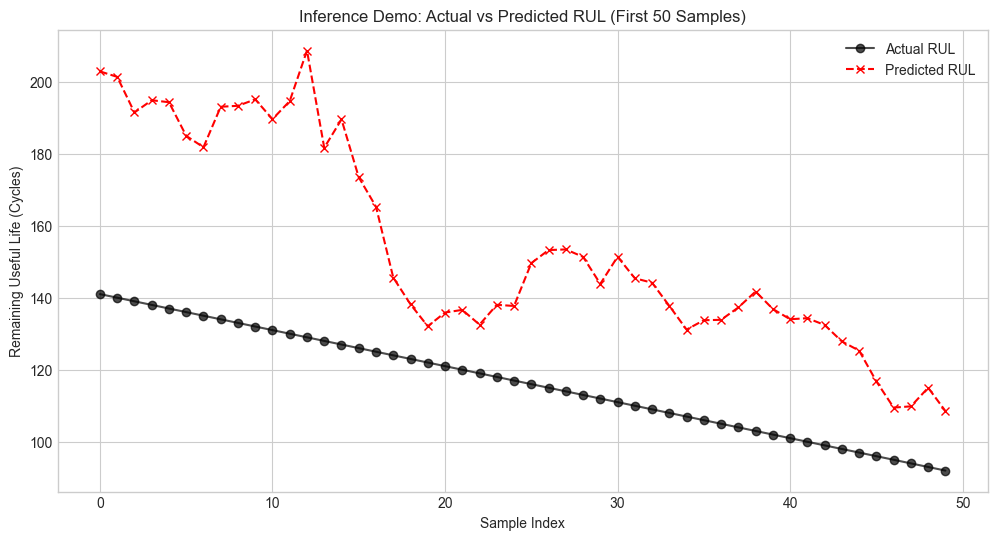

In [17]:
y_true = []
y_pred = []

# run inference on first 50 samples
print("Running batch inference...")
with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        if i >= 50: break # stop after 50 samples
        
        inputs = inputs.to(device)
        out = model(inputs)
        
        y_true.append(targets.item())
        y_pred.append(out.item())

# plot
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual RUL', marker='o', linestyle='-', color='black', alpha=0.7)
plt.plot(y_pred, label='Predicted RUL', marker='x', linestyle='--', color='red')
plt.title('Inference Demo: Actual vs Predicted RUL (First 50 Samples)')
plt.ylabel('Remaining Useful Life (Cycles)')
plt.xlabel('Sample Index')
plt.legend()
plt.show()